# PRNN Crabs dataset
Highly correlated features (real data!). 
The additive mothernet seems to do well here.

In the validation set, the data contains the index, which leaks information. Whether or not we include the leaking index, the conclusions here seem to be the same.

In [1]:
from sklearn.datasets import fetch_openml
import warnings
warnings.simplefilter("ignore", FutureWarning)

In [2]:
data = fetch_openml("prnn_crabs")

Target looks like classification
Linear Discriminant Analysis training set score: 1.000


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='sp'>,
 [<Figure size 1200x400 with 6 Axes>,
  array([[<Axes: title={'center': '0.933'}, xlabel='BD', ylabel='index'>,
          <Axes: title={'center': '0.900'}, xlabel='FL', ylabel='index'>,
          <Axes: title={'center': '0.833'}, xlabel='FL', ylabel='CW'>,
          <Axes: title={'center': '0.833'}, xlabel='FL', ylabel='CL'>]],
        dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 640x480 with 1 Axes>],
 array([[<Axes: title={'center': 'sex'}>]], dtype=object)]

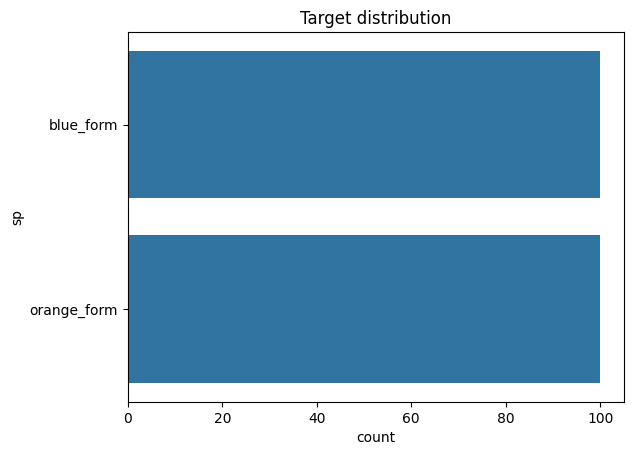

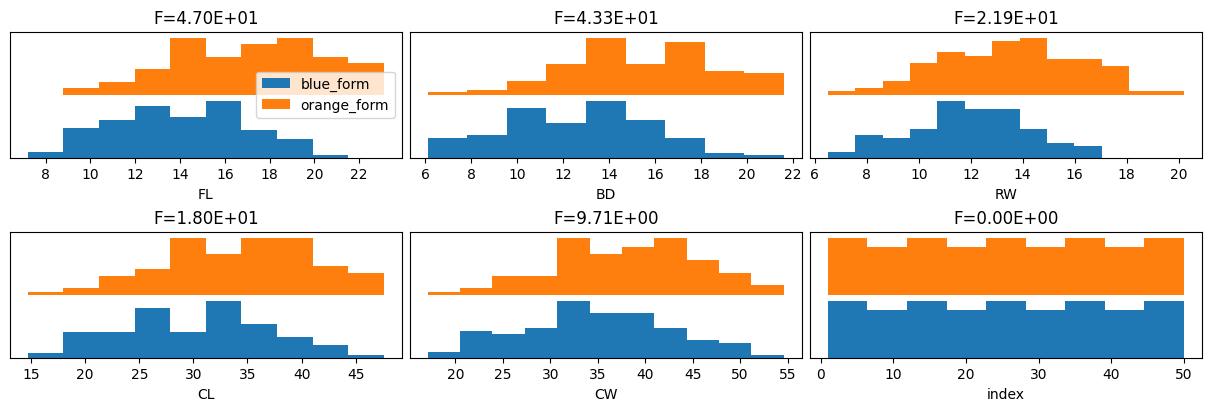

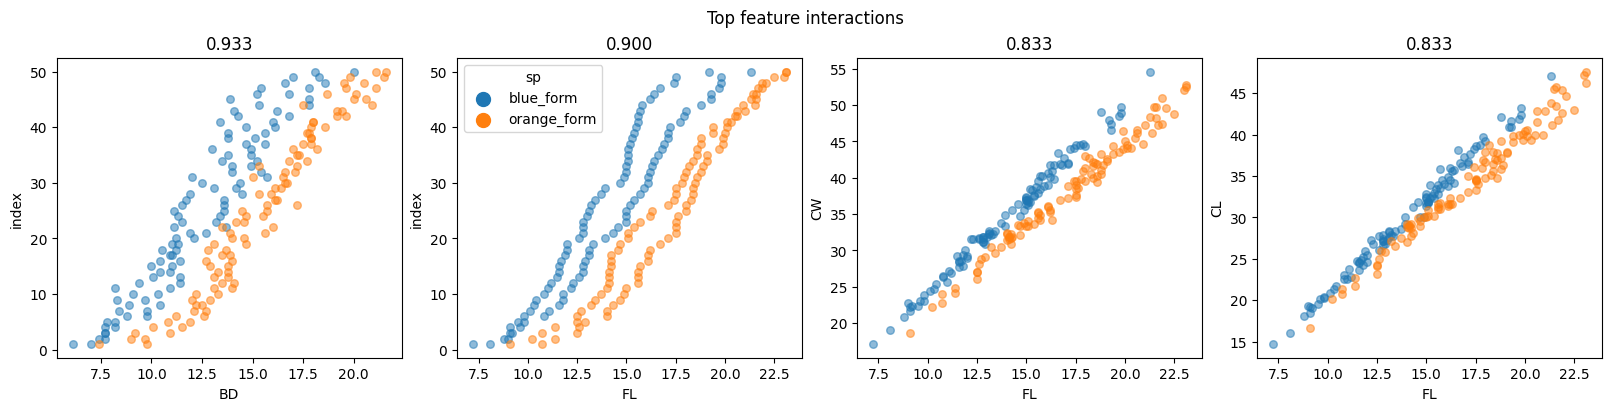

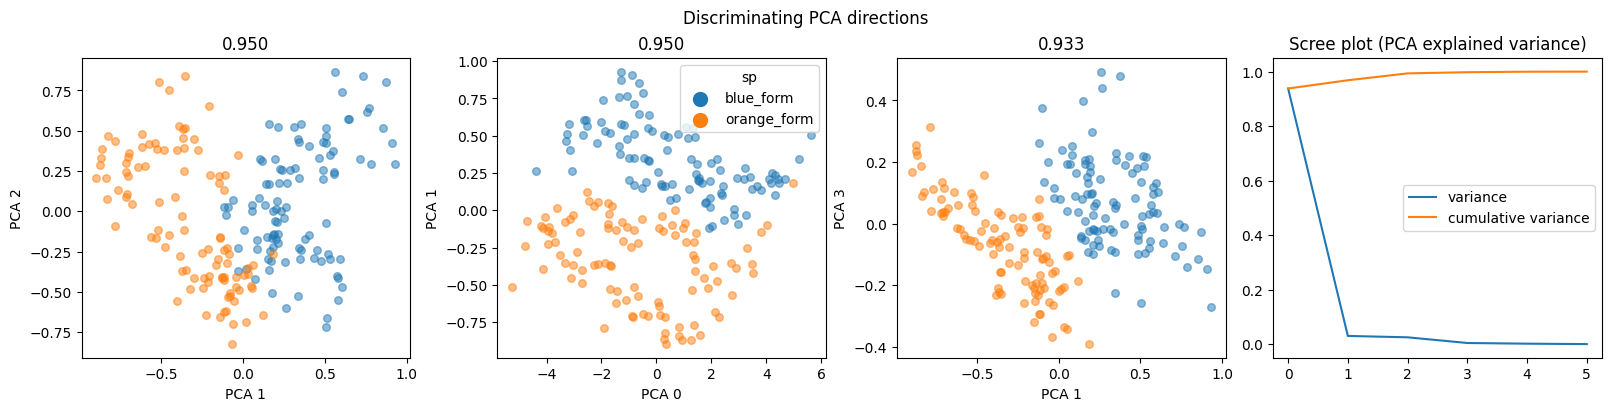

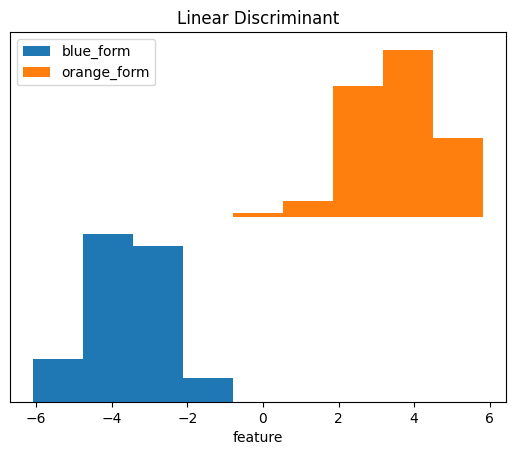

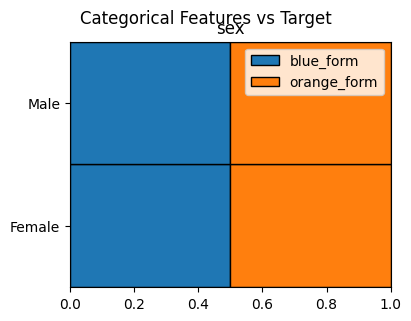

In [3]:
from dabl import plot

plot(data.frame, target_col="sp")

In [4]:
data.data

,sex,index,FL,RW,CL,CW,BD
0,Male,1,8.1,6.7,16.1,19.0,7.0
1,Male,2,8.8,7.7,18.1,20.8,7.4
2,Male,3,9.2,7.8,19.0,22.4,7.7
3,Male,4,9.6,7.9,20.1,23.1,8.2
4,Male,5,9.8,8.0,20.3,23.0,8.2
...,...,...,...,...,...,...,...
195,Female,46,21.4,18.0,41.2,46.2,18.7
196,Female,47,21.7,17.1,41.7,47.2,19.6
197,Female,48,21.9,17.2,42.6,47.4,19.5
198,Female,49,22.5,17.2,43.0,48.7,19.8


In [5]:
from sklearn.model_selection import train_test_split

from interpret.glassbox import ExplainableBoostingClassifier

ebm_bins_main_effects = ExplainableBoostingClassifier(max_bins=64, interactions=0)

X_train, X_test, y_train, y_test = train_test_split(data.data.drop(columns="index"), data.target, stratify=data.target, train_size=0.5, random_state=13)

In [6]:
ebm_bins_main_effects.fit(X_train, y_train)

ExplainableBoostingClassifier(interactions=0, max_bins=64)

In [7]:
ebm_bins_main_effects.score(X_test, y_test)

0.72

In [8]:
from ticl.prediction.mothernet import ShiftClassifier, EnsembleMeta, MotherNetClassifier
from ticl.prediction.mothernet_additive import MotherNetAdditiveClassifier
from ticl.utils import get_mn_model
import numpy as np

device = "cpu"
model_string = "additive_1_gpu_02_14_2024_16_34_15_epoch_950_fixed2.cpkt"
model_path = get_mn_model(model_string)
additive = MotherNetAdditiveClassifier(path=model_path, device=device)


/anaconda/envs/tabpfn_testing_environment/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
X_train_bool = X_train.copy()
X_train_bool['sex'] = (X_train['sex'] == "Female").astype(int)

In [10]:
X_test_bool = X_test.copy()
X_test_bool['sex'] = (X_test['sex'] == "Female").astype(int)

In [11]:
additive.fit(np.array(X_train_bool), y_train)

MotherNetAdditiveClassifier(path='../models_diff/additive_1_gpu_02_14_2024_16_34_15_epoch_950_fixed2.cpkt')

In [12]:
additive.score(np.array(X_test_bool), y_test)

0.93

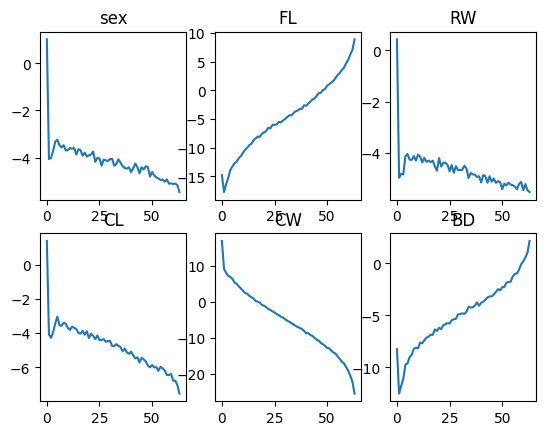

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3)
for i in range(6):
    ax = axes.ravel()[i]
    ax.plot(additive.w_[i, :, 1])
    ax.set_title(X_train.columns[i])
    

In [14]:
from interpret import show

show(ebm_bins_main_effects.explain_global())

In [15]:
ta = fetch_openml("teachingAssistant")

<Axes: xlabel='ID', ylabel='class'>

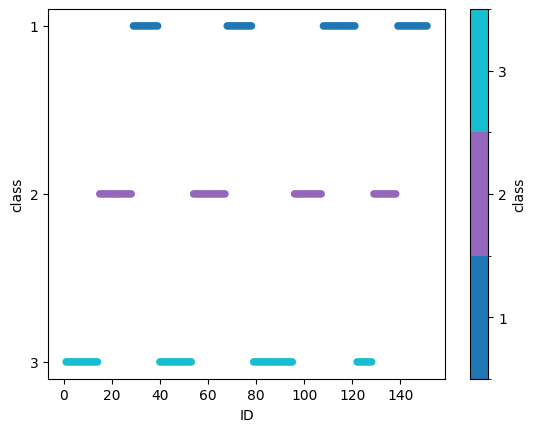

In [41]:
ta.frame.plot(x="ID", y="class", kind="scatter", c="class", cmap="tab10")

In [17]:
X_train, X_test, y_train, y_test = train_test_split(ta.data, ta.target, stratify=ta.target, train_size=0.5, random_state=13)

In [18]:
X_train

,ID,EnglishSepaker,courseInstructor,course,summer,classSize
128,129.0,2,22,1,2,11.0
148,149.0,1,18,7,2,48.0
50,51.0,2,13,1,2,30.0
84,85.0,1,22,3,2,45.0
0,1.0,1,23,3,1,19.0
...,...,...,...,...,...,...
35,36.0,2,16,8,2,36.0
101,102.0,2,23,3,1,20.0
31,32.0,2,18,5,2,19.0
83,84.0,2,18,21,2,19.0


In [19]:
ebm_bins_main_effects = ExplainableBoostingClassifier(max_bins=64, interactions=0)
ebm_bins_main_effects.fit(X_train, y_train)

ExplainableBoostingClassifier(interactions=0, max_bins=64)

In [20]:
ebm_bins_main_effects.score(X_test, y_test)

0.7763157894736842

In [21]:
show(ebm_bins_main_effects.explain_global())

In [22]:
additive = MotherNetAdditiveClassifier(path="../models_diff/additive_1_gpu_02_14_2024_16_34_15_epoch_950_fixed2.cpkt", device=device)
additive.fit(np.array(X_train.astype(float)), y_train)

MotherNetAdditiveClassifier(path='../models_diff/additive_1_gpu_02_14_2024_16_34_15_epoch_950_fixed2.cpkt')

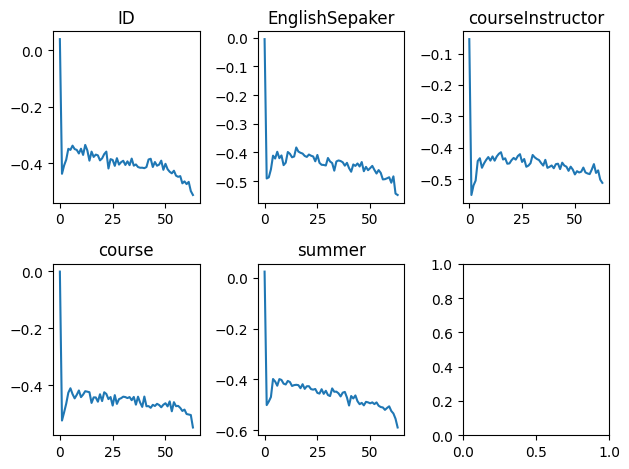

In [23]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3)
for i in range(5):
    ax = axes.ravel()[i]
    ax.plot(additive.w_[i, :, 1])
    ax.set_title(X_train.columns[i])
plt.tight_layout()

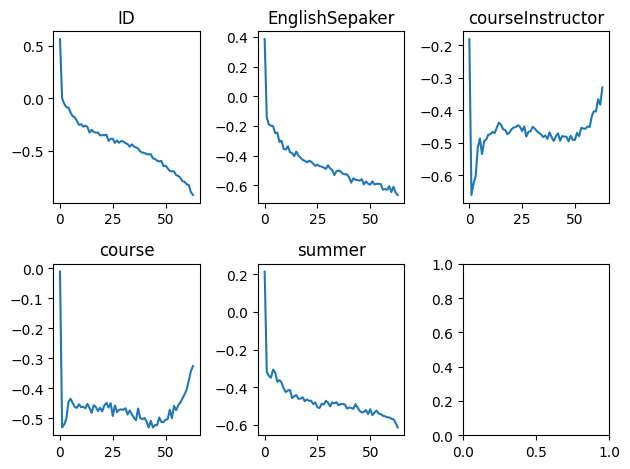

In [24]:
fig, axes = plt.subplots(2, 3)

for i in range(5):
    ax = axes.ravel()[i]
    ax.plot(additive.w_[i, :, 2])
    ax.set_title(X_train.columns[i])
plt.tight_layout()

# Tuning SVMs dataset
As many samples as there are features basically?!

In [25]:
svm = fetch_openml("TuningSVMs", version=1)

Target looks like classification
Showing only top 10 of 74 continuous features


/anaconda/envs/tabpfn_testing_environment/lib/python3.11/site-packages/dabl/plot/utils.py:704: UserWarning:

Dropped 1 outliers in column dcomp.f2.



Linear Discriminant Analysis training set score: 0.863


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='Class'>,
 [<Figure size 2000x400 with 10 Axes>,
  array([[<Axes: title={'center': '0.756'}, xlabel='landmarking.stump_sd', ylabel='dcomp.n1'>,
          <Axes: title={'center': '0.728'}, xlabel='simple.class_prob_sd', ylabel='inftheo.normalize...'>,
          <Axes: title={'center': '0.694'}, xlabel='landmarking.stump_sd', ylabel='inftheo.normalize...'>,
          <Axes: title={'center': '0.694'}, xlabel='landmarking.stump_sd', ylabel='dcomp.l3'>]],
        dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 640x480 with 1 Axes>],
 array([[<Axes: title={'center': 'simple.classes'}>,
         <Axes: title={'center': 'modelbased.level_mean'}>,
         <Axes: title={'center': 'simple.symbols_min'}>,
         <Axes: title={'center': 'modelbased.attribute_max'}>,
         <Axes: title={'center': 'modelbased.branch_max'}>]], dtype=object)]

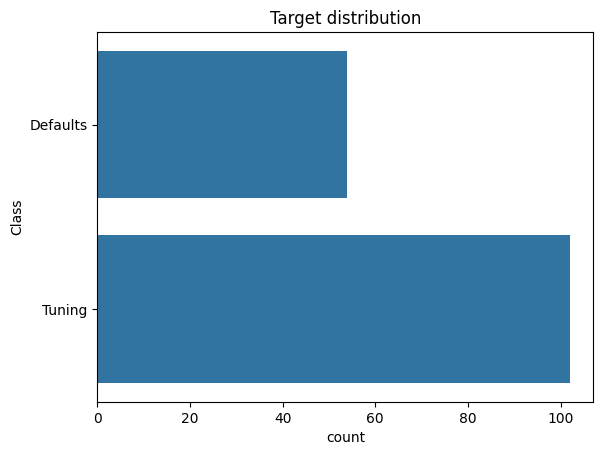

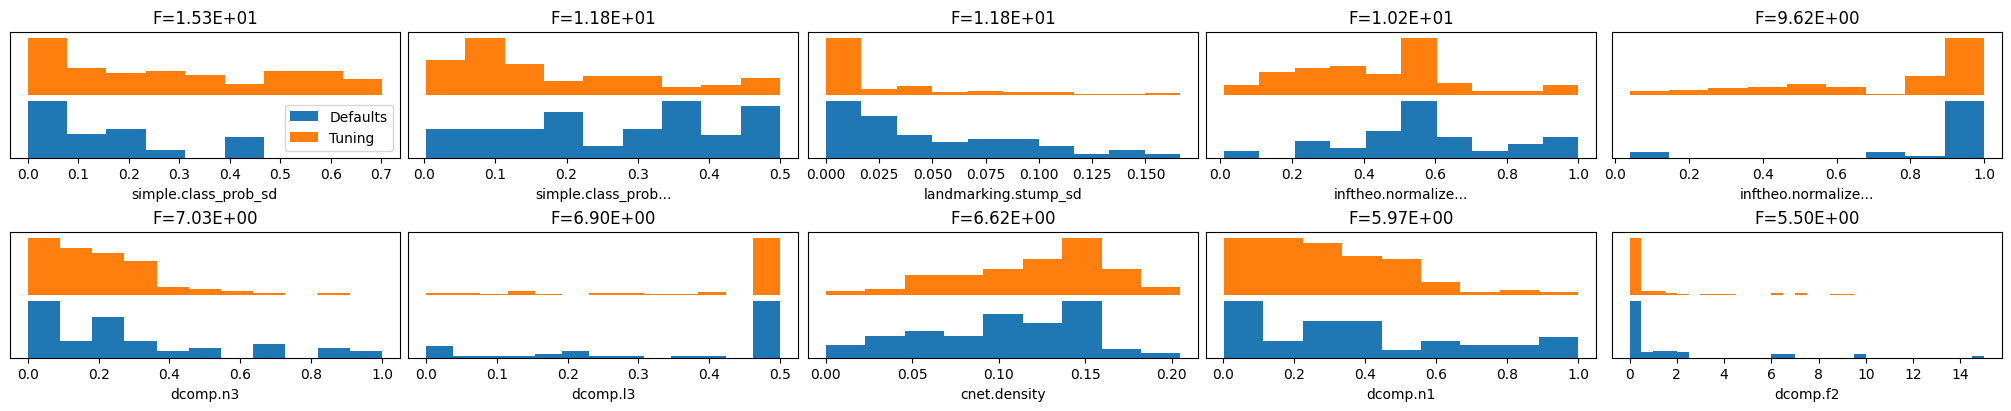

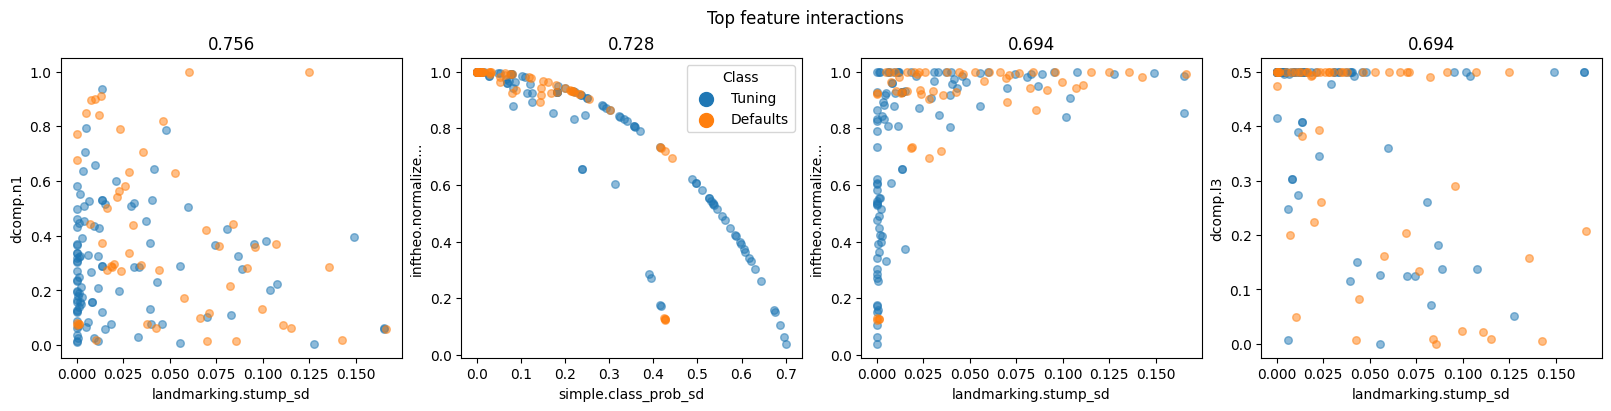

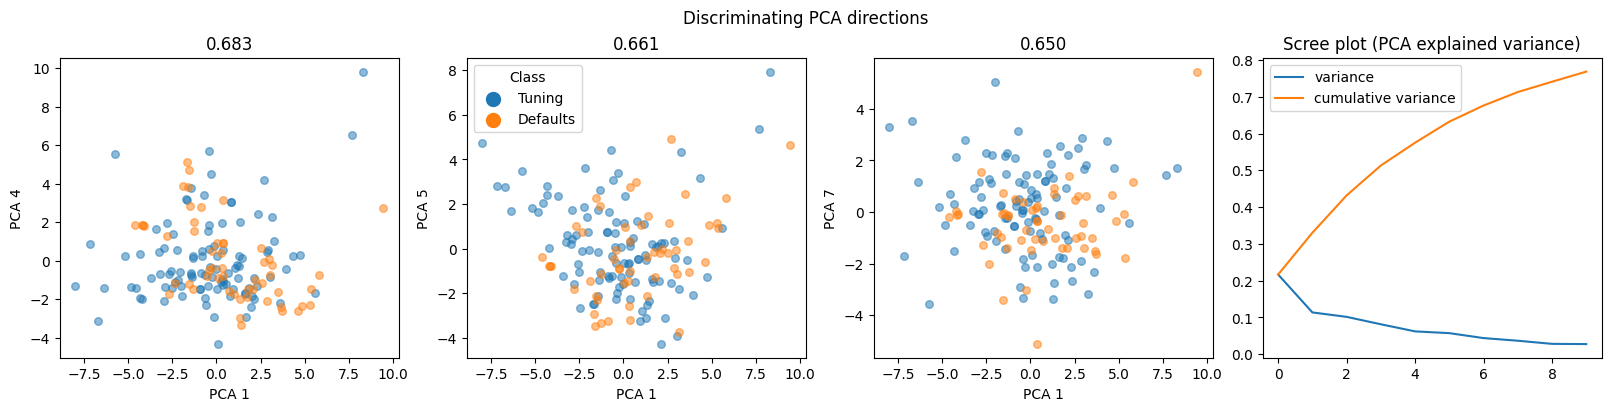

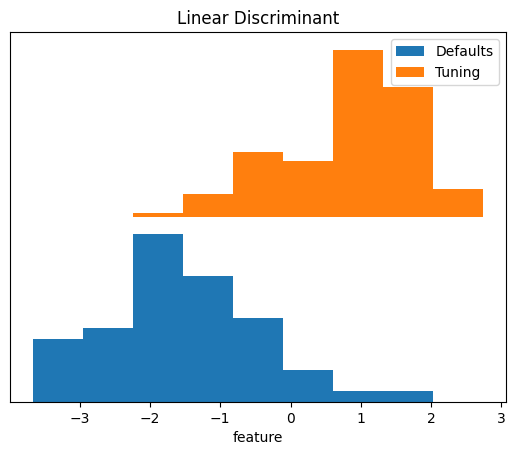

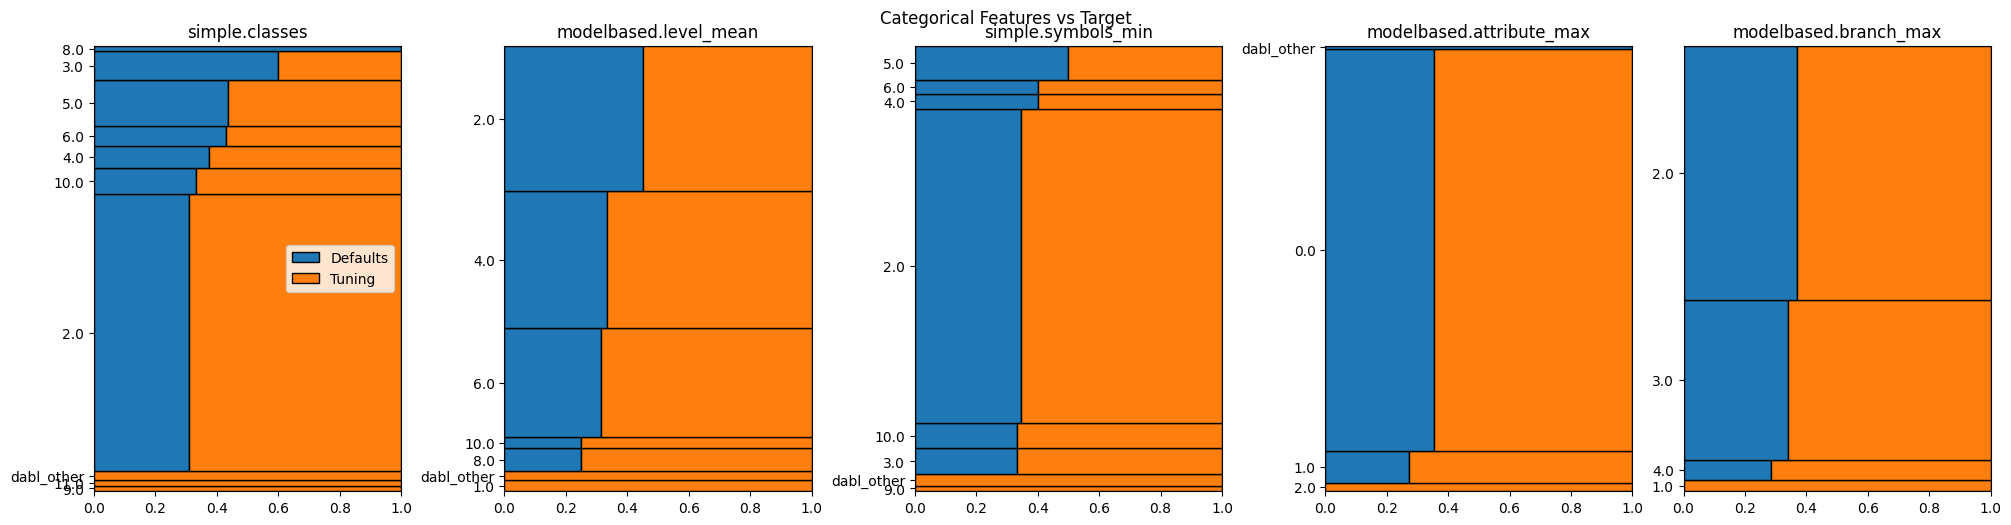

In [26]:
plot(svm.frame, target_col=svm.target_names[0])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(svm.data, svm.target, stratify=svm.target, train_size=0.5, random_state=13)

In [28]:
ebm_bins_main_effects = ExplainableBoostingClassifier(max_bins=64, interactions=0)
ebm_bins_main_effects.fit(X_train, y_train)

ExplainableBoostingClassifier(interactions=0, max_bins=64)

In [29]:
ebm_bins_main_effects.score(X_test, y_test)

0.7307692307692307

In [30]:
show(ebm_bins_main_effects.explain_global())

In [31]:
additive = MotherNetAdditiveClassifier(path="../models_diff/additive_1_gpu_02_14_2024_16_34_15_epoch_950_fixed2.cpkt", device=device)
additive.fit(np.array(X_train.astype(float)), y_train)

MotherNetAdditiveClassifier(path='../models_diff/additive_1_gpu_02_14_2024_16_34_15_epoch_950_fixed2.cpkt')

In [32]:
additive.score(np.array(X_test.astype(float)), y_test)

0.6538461538461539

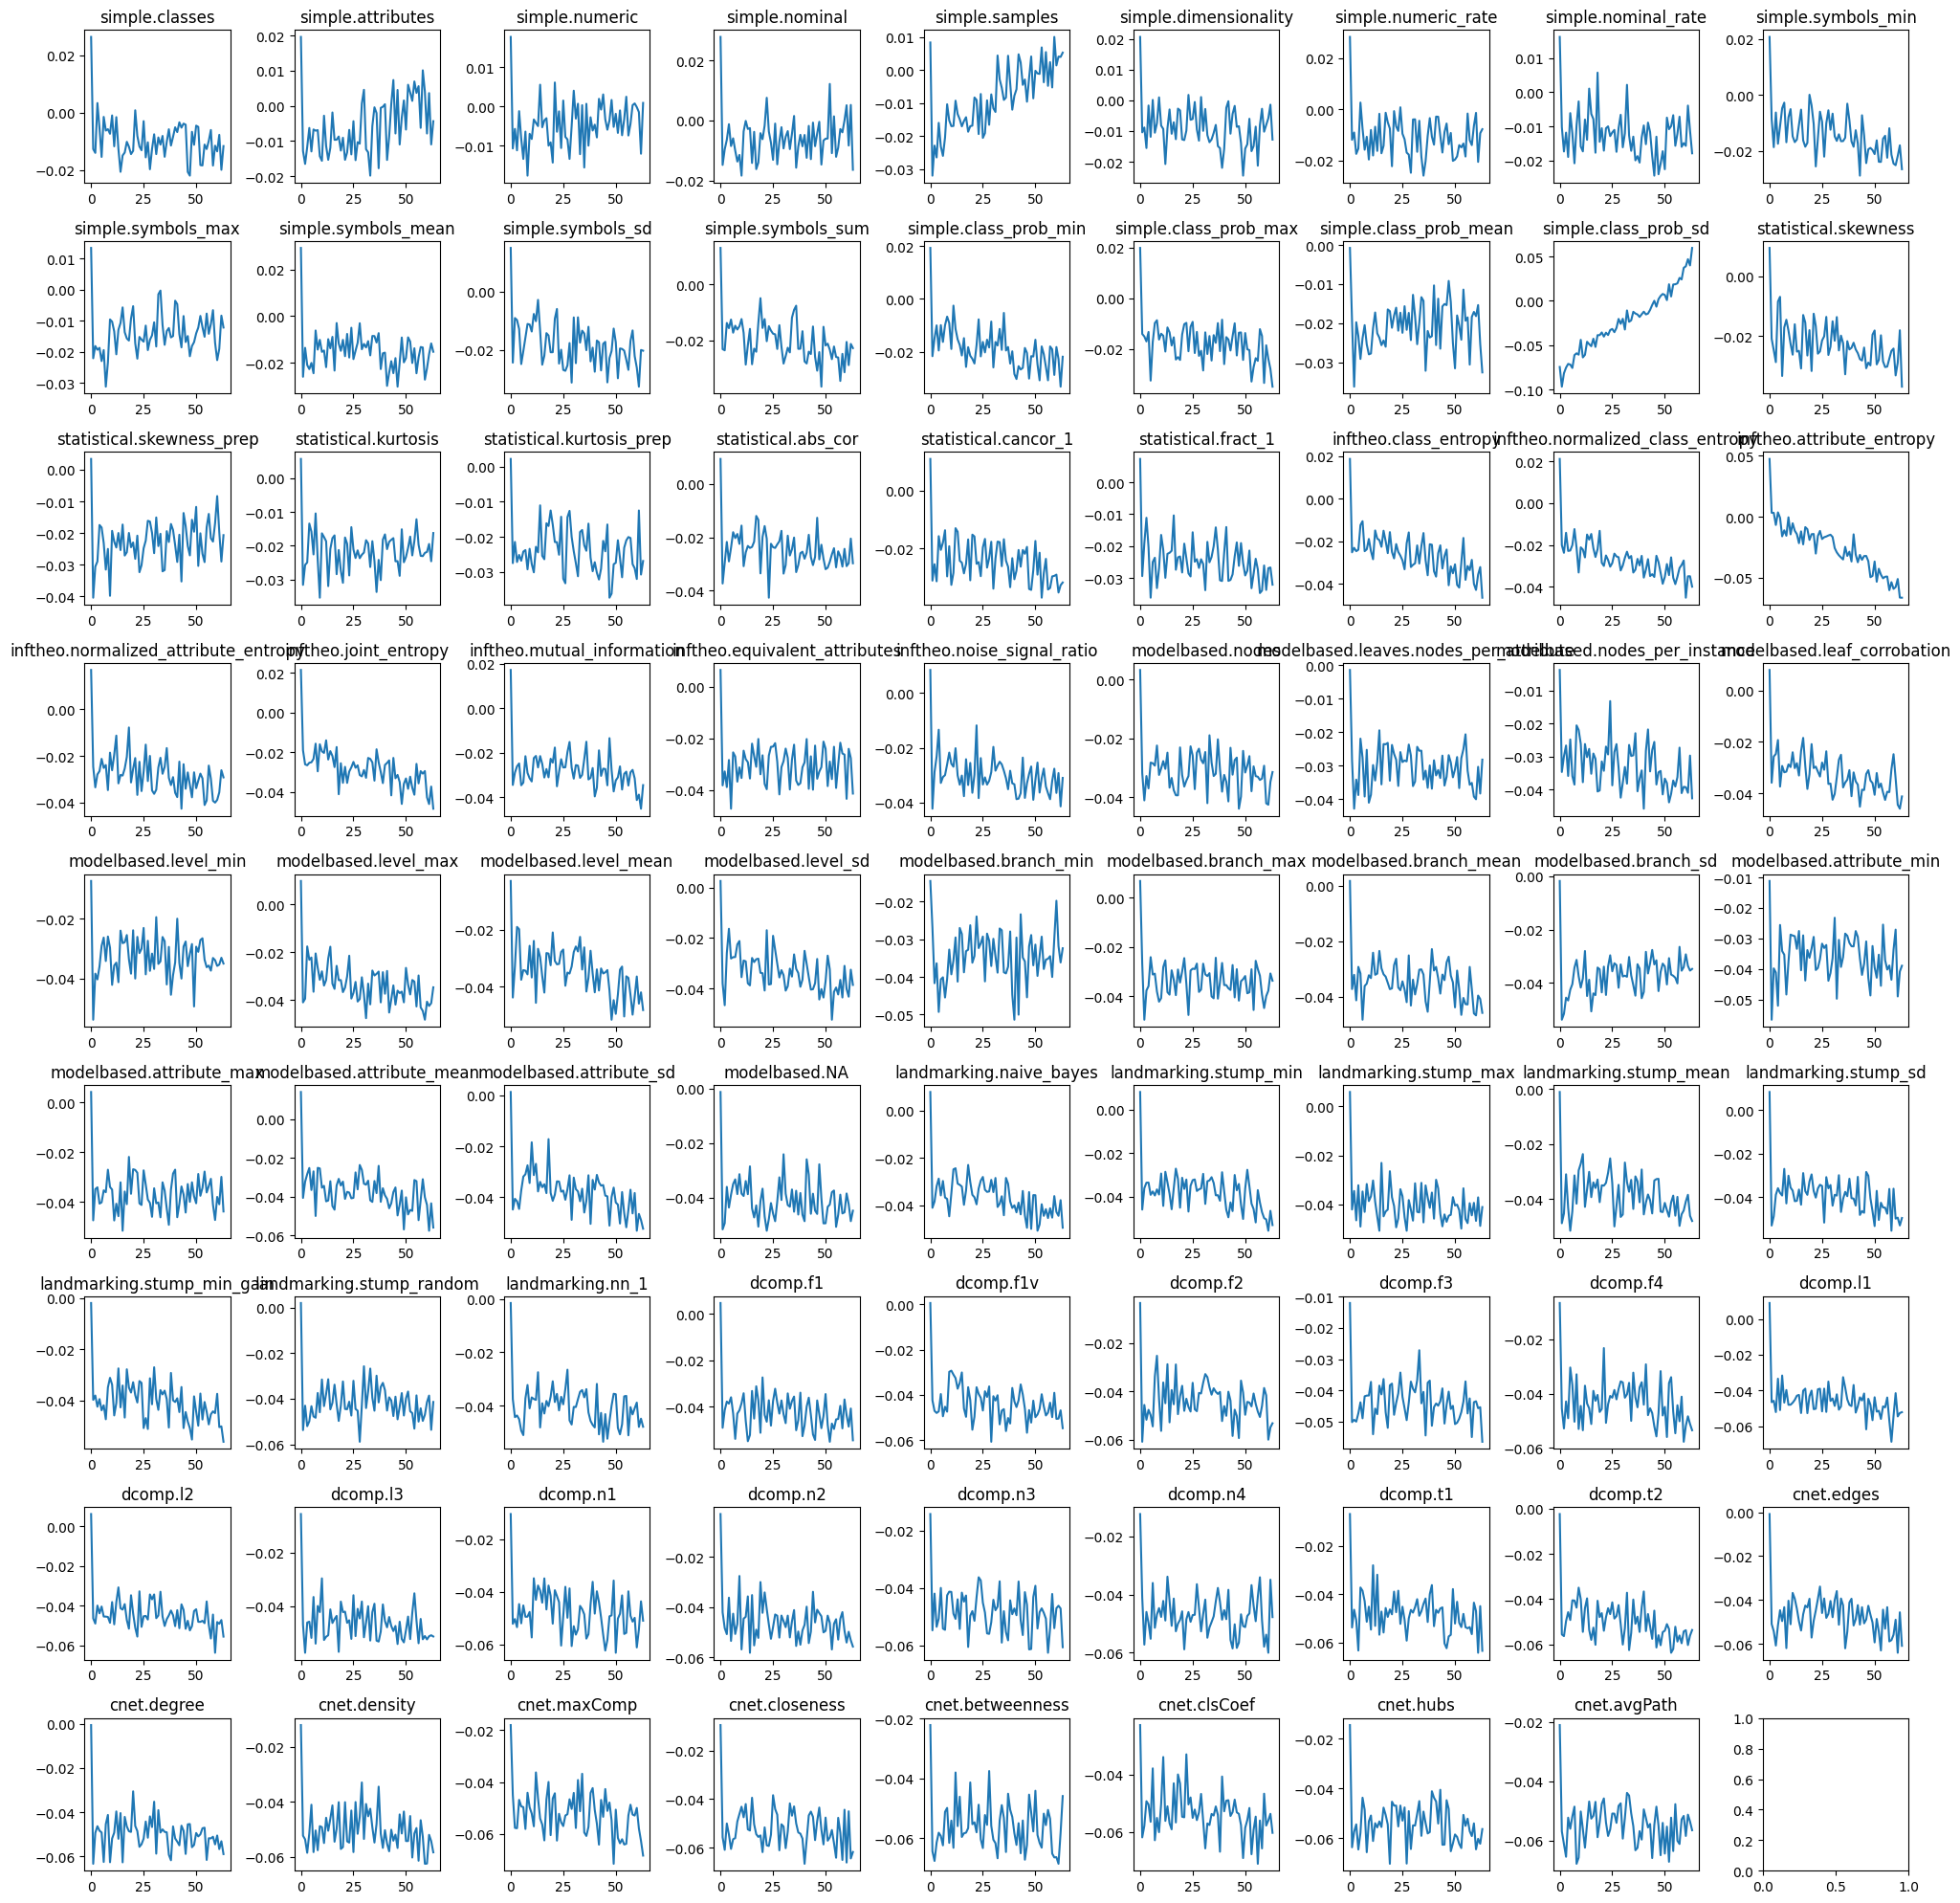

In [33]:
fig, axes = plt.subplots(9, 9, figsize=(20, 20))

for i in range(80):
    ax = axes.ravel()[i]
    ax.plot(additive.w_[i, :, 1])
    ax.set_title(X_train.columns[i])
plt.tight_layout()